# Pomiar szybkości uczenia się

Ten notatnik implementuje prosty, w pełni połączony model klasyfikujący cyfry MNIST. Badamy szybkość uczenia się modelu w zależności od liczby warstw ukrytych.

#### Zainicjowanie generatora liczb losowych.

In [ ]:
import numpy as np
np.random.seed(42)

#### Załadowanie zależności.


In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout # new!
from keras import backend as K
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
%matplotlib inline

#### Zdefiniowanie niestandardowej funkcji zwrotnej.

In [ ]:
class GradHistory(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        # Zainicjowaie listy warstw ukrytych.
        self.layers = [layer for layer in self.model.layers if 'hidden_' in layer.name]
        
        # Urworzenie pustej listy gradientów.
        self.grads = {layer.name:[] for layer in self.layers}
        
        # Wybranie początkowych wag.
        self.prev_w = [layer.get_weights()[0] for layer in self.layers]

    def on_epoch_end(self, batch, logs={}):
        # Wybranie wag na końiec każdej epoki.
        curr_w = [layer.get_weights()[0] for layer in self.layers]
        
        # Wybranie szybkości uczenia na koniec każdej epoki.
        lr = K.get_value(self.model.optimizer.lr)
        
        # Konwersja poprzednich i bieżących wag na gradienty.
        grads_ = [(prev - curr) for curr, prev in zip(curr_w, self.prev_w)]
        
        # Przeniesienie gradientów do słownika self.grads.
        for i,layer in enumerate(grads_):
            self.grads[self.layers[i].name].append(layer)
        self.prev_w = curr_w
    
    def on_train_end(self, logs={}):
        # Na koniec treningu wyliczana jest odległość euklidesowa dla każdej tablicy gradientów, każdej warstwy i każdej epoki.
        self.norms = {k:[np.sqrt(np.sum([x*x for x in epoch])) for epoch in v] for k,v in self.grads.items()}

#### Załadowanie danych.


In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


#### Wstępne przetworzenie danych.


In [ ]:
X_train = X_train.reshape(60000, 784).astype('float32')
X_test = X_test.reshape(10000, 784).astype('float32')

In [ ]:
X_train /= 255
X_test /= 255

In [ ]:
n_classes = 10
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

#### Architektura sieci neuronowej.


In [ ]:
def build_model(hidden = 2):
    
    model = Sequential()
    model.add(Dense(30, activation='sigmoid', input_shape=(784,),name='input'))
    
    for h in range(hidden):
        model.add(Dense(30, activation='sigmoid',name='hidden_{}'.format(h)))
    
    model.add(Dense(10, activation='softmax'))
    
    return model

#### Utworzenie, skompilowanie i przetrenowanie modelu.

In [ ]:
def build_and_train(hidden = 1, epochs=200):
    
    model = build_model(hidden)
    history = GradHistory()
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    model.fit(X_train[:1000], y_train[:1000], batch_size=1, epochs=epochs, verbose=0, callbacks=[history])
    
    return history

Zmienna `history.grads.norms` jest to słownik z kluczami dla każdej warstwy modelu. Każdy klucz zawiera listę znormalizowanych wartościgradientu dla danej warstwy we wszystkich epokach treningowych.

In [ ]:
# Pięć ukrytych warstw i 200 epok.
norms_5 = build_and_train(5, 200)

#### Define a plotting function

In [ ]:
def plot(history, hidden, log=False):   
    fig = plt.figure(figsize=(8,6),dpi=300)
    
    layers = [layer for layer in history.norms.keys()]
    values = [history.norms[layer] for layer in layers]
    
    for layer,values in zip(layers[::-1],values[::-1]):
        ys = np.array(values[:])
        xs = np.array(range(ys.shape[0]))
        ys_smooth = gaussian_filter1d(ys, sigma=3)
        plt.plot(xs, ys_smooth, label=layer)
        
    plt.title('Szybkość uczenia dla {} warstw ukrytych'.format(hidden))
    plt.ylabel('Szybkość uczenia')
    if log:
        plt.yscale('log')
    plt.xlabel('Epoka')
    plt.legend(loc='upper right')
    plt.show()

#### Plot the results

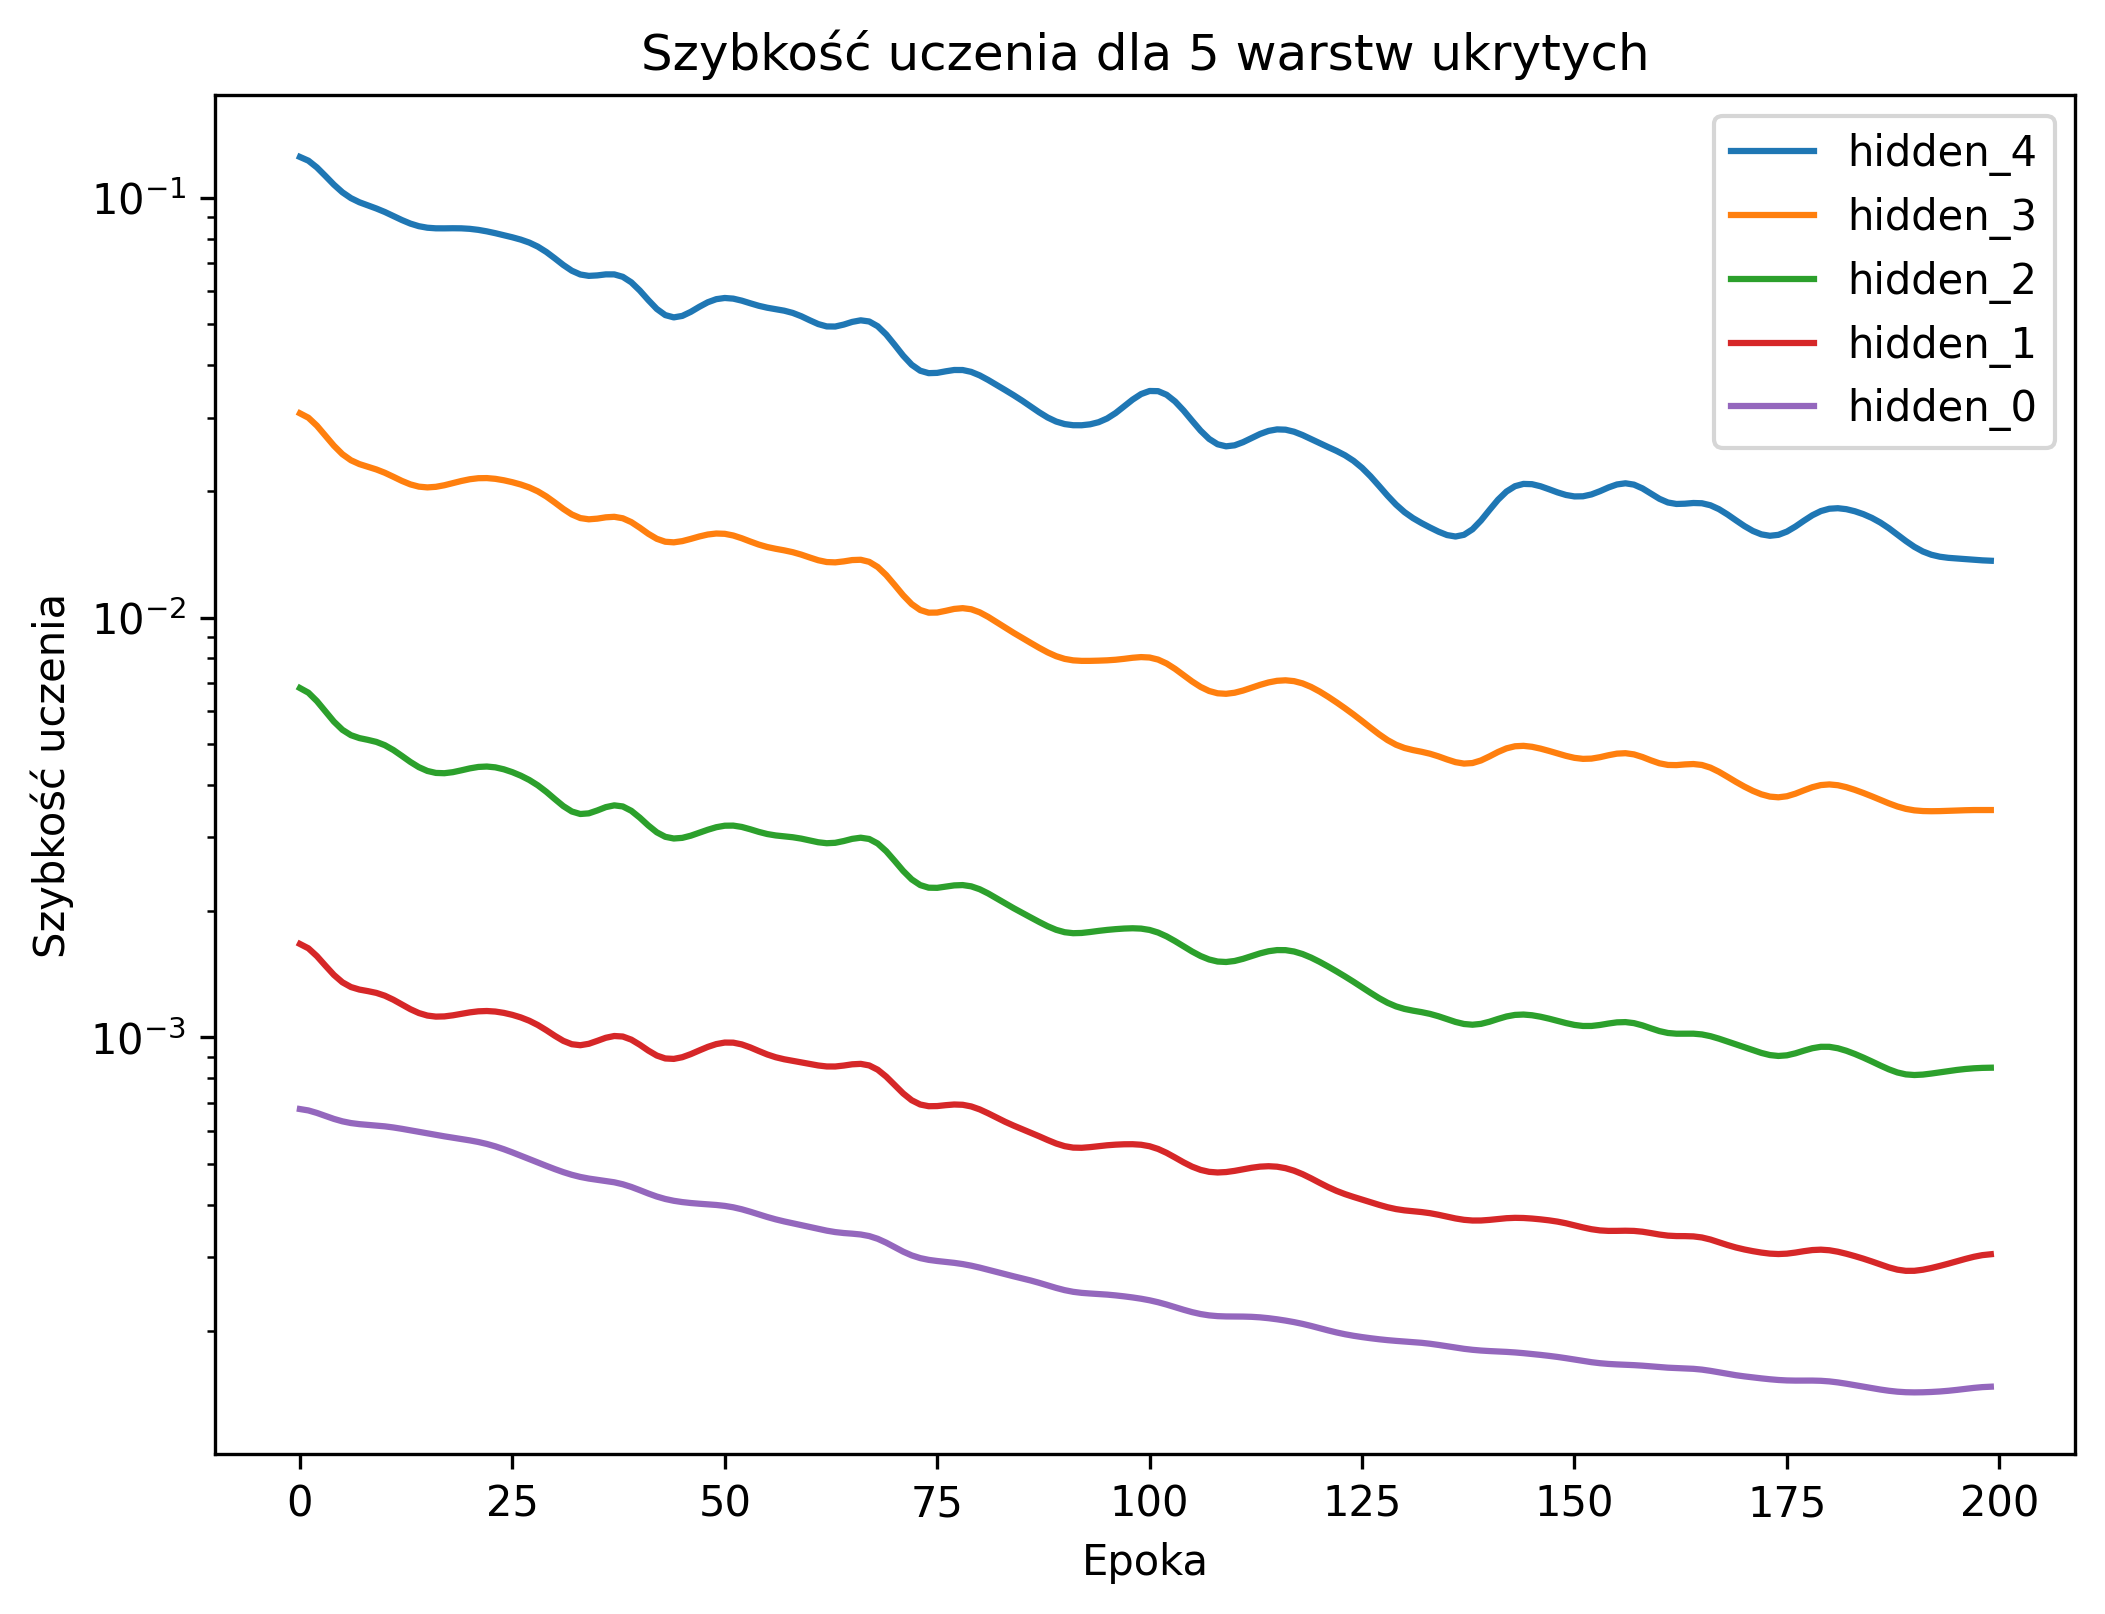

In [ ]:
plot(norms_5, 5, True)